In [13]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

from datetime import date, datetime, timedelta
import time

t0 = time.time()

# Read recipe inputs
NAFCUSTOMER_REVENUE_AGGREGATED = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED")
NAFCUSTOMER_REVENUE_AGGREGATED_df = NAFCUSTOMER_REVENUE_AGGREGATED.get_dataframe()

t1 = time.time()
print("load duration", (t1-t0)/60.0, "minutes")

print(len(NAFCUSTOMER_REVENUE_AGGREGATED_df))
NAFCUSTOMER_REVENUE_AGGREGATED_df.head()

load duration 5.3527179996172585 minutes
18075044


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_MONTH,SETUP_DATE,BI_CUS_PAR,BI_PRODUCT,BI_MRU,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,PURCHASE_GALLONS_QTY,TOTAL_ACTIVE_CARD_COUNT
0,77056151.0,ARM HEALTHCARE L L C,2019,11,2019-03-15 07:00:00+00:00,30300.0,15308.0,3100.0,222.240507,6448.90,2712.729,47.0
1,77618991.0,VERITAS MANAGED SOLUTIONS INC,2020,11,2011-05-19 07:00:00+00:00,12200.0,15100.0,4120.0,40.630000,3692.88,1143.368,16.0
2,77318531.0,JNM ENTERPRISES INC,2020,10,2016-04-06 07:00:00+00:00,51000.0,10100.0,4120.0,25.320000,741.35,355.677,13.0
3,77058685.0,ASHEVILLE ELEVATOR COMPANY INC,2019,4,2007-03-29 07:00:00+00:00,51000.0,10100.0,3100.0,87.610000,1569.19,569.249,7.0
4,77221508.0,FAST JACK TRANSPORT,2019,9,2018-10-26 07:00:00+00:00,21000.0,15110.0,4000.0,28.570000,909.94,334.750,3.0


In [0]:
# create date column, combining month and year
# group revenue sum by date column

In [14]:
print(len(NAFCUSTOMER_REVENUE_AGGREGATED_df))
df = NAFCUSTOMER_REVENUE_AGGREGATED_df

18075044


In [15]:
df.head()

,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_MONTH,SETUP_DATE,BI_CUS_PAR,BI_PRODUCT,BI_MRU,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,PURCHASE_GALLONS_QTY,TOTAL_ACTIVE_CARD_COUNT
0,77056151.0,ARM HEALTHCARE L L C,2019,11,2019-03-15 07:00:00+00:00,30300.0,15308.0,3100.0,222.240507,6448.90,2712.729,47.0
1,77618991.0,VERITAS MANAGED SOLUTIONS INC,2020,11,2011-05-19 07:00:00+00:00,12200.0,15100.0,4120.0,40.630000,3692.88,1143.368,16.0
2,77318531.0,JNM ENTERPRISES INC,2020,10,2016-04-06 07:00:00+00:00,51000.0,10100.0,4120.0,25.320000,741.35,355.677,13.0
3,77058685.0,ASHEVILLE ELEVATOR COMPANY INC,2019,4,2007-03-29 07:00:00+00:00,51000.0,10100.0,3100.0,87.610000,1569.19,569.249,7.0
4,77221508.0,FAST JACK TRANSPORT,2019,9,2018-10-26 07:00:00+00:00,21000.0,15110.0,4000.0,28.570000,909.94,334.750,3.0


In [19]:
df.REVENUE_MONTH.value_counts()

1     1779756
10    1517545
11    1515964
12    1511510
9     1510512
8     1490223
7     1486083
6     1482134
5     1471147
4     1455710
3     1441540
2     1412920
Name: REVENUE_MONTH, dtype: int64

In [21]:
df[]

df['REVENUE_DATE'] = df['REVENUE_MONTH'].astype(str) + '-' + df['REVENUE_YEAR'].astype(str)
df['REVENUE_DATE'] = pd.to_datetime(df['REVENUE_DATE'], format='%m-%Y').dt.strftime('%m-%Y')
df.head()

,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_MONTH,SETUP_DATE,BI_CUS_PAR,BI_PRODUCT,BI_MRU,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,PURCHASE_GALLONS_QTY,TOTAL_ACTIVE_CARD_COUNT,REVENUE_DATE
0,77056151.0,ARM HEALTHCARE L L C,2019,11,2019-03-15 07:00:00+00:00,30300.0,15308.0,3100.0,222.240507,6448.90,2712.729,47.0,11-2019
1,77618991.0,VERITAS MANAGED SOLUTIONS INC,2020,11,2011-05-19 07:00:00+00:00,12200.0,15100.0,4120.0,40.630000,3692.88,1143.368,16.0,11-2020
2,77318531.0,JNM ENTERPRISES INC,2020,10,2016-04-06 07:00:00+00:00,51000.0,10100.0,4120.0,25.320000,741.35,355.677,13.0,10-2020
3,77058685.0,ASHEVILLE ELEVATOR COMPANY INC,2019,4,2007-03-29 07:00:00+00:00,51000.0,10100.0,3100.0,87.610000,1569.19,569.249,7.0,04-2019
4,77221508.0,FAST JACK TRANSPORT,2019,9,2018-10-26 07:00:00+00:00,21000.0,15110.0,4000.0,28.570000,909.94,334.750,3.0,09-2019


In [26]:
df_revenue_per_month = df.groupby(['REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()
df_revenue_per_month.head()

,REVENUE_YEAR,REVENUE_AMOUNT_USD
0,2019,6.118864e+08
1,2020,5.089365e+08
2,2021,6.331536e+08
3,2022,8.833046e+08
4,2023,7.100172e+07


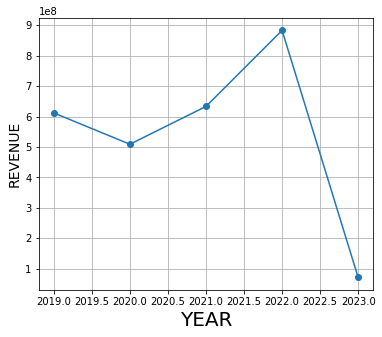

In [28]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(6,5))
ax1.plot(df_revenue_per_month['REVENUE_YEAR'],df_revenue_per_month['REVENUE_AMOUNT_USD'], marker='o')
ax1.set_xlabel('YEAR', fontsize=20)
ax1.set_ylabel('REVENUE', fontsize=14)
ax1.grid()

plt.show()

In [0]:
# Compute recipe outputs from inputs
# TODO: Replace this part by your actual code that computes the output, as a Pandas dataframe
# NB: DSS also supports other kinds of APIs for reading and writing data. Please see doc.

#TENURE_CALC_df = NAFCUSTOMER_REVENUE_AGGREGATED_df # For this sample code, simply copy input to output


# Write recipe outputs
#TENURE_CALC = dataiku.Dataset("TENURE_CALC")
#TENURE_CALC.write_with_schema(TENURE_CALC_df)